Goal is the implement the Spin-Glass Modell of Weiss (Chapter 6) to reproduce the results

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display
import LogBeliefPropagation

In [26]:
np.random.seed(4589)
# np.seterr(all="raise")
np.seterr(all="warn")

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

In [27]:
num_models = 1000
max_iters = 1000

In [28]:
degree1_adjacency = np.eye(9, dtype=int)
degree2_adjacency = np.array([
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1],

    [1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 1]
], dtype=int)
adjacency_matrix = np.concatenate((degree1_adjacency, degree2_adjacency), dtype=int)

degree1_factors = np.random.randn(num_models, 9).reshape(num_models, 9, 1, 1) * -0.4 * np.array([[1, 1], [-1, -1]]).reshape(1, 1, 2, 2) # shape (num_models, 9, 2, 2)
degree2_factors = np.random.randn(num_models, 12).reshape(num_models, 12, 1, 1) * -1.0 * np.array([[1, -1], [-1, 1]]).reshape(1, 1, 2, 2)
log_factors = np.array([np.concatenate((degree1_factors[model_idx], degree2_factors[model_idx]), axis=0) for model_idx in range(num_models)])

In [29]:
bp = LogBeliefPropagation.LogBeliefPropagation(adjacency_matrix, state_domain_size=2)
c_var = bp.c_var_DefaultCBP()
print(c_var)
print(bp.dv / (2 - c_var))
gamma = bp.gammaDefaultCBP()
print(gamma)
gamma = bp.dv / (2 - c_var)

[-2.  -2.5 -2.  -2.5 -3.  -2.5 -2.  -2.5 -2. ]
[0.75       0.88888889 0.75       0.88888889 1.         0.88888889
 0.75       0.88888889 0.75      ]
[1.         1.14285714 1.         1.14285714 1.25       1.14285714
 1.         1.14285714 1.        ]


In [30]:
var_beliefs = np.empty((num_models, 9, 2))
check_beliefs = np.empty((num_models, bp.m) + bp.df_max * (2,))
iterations = np.empty(var_beliefs.shape[0])

progress_bar = IntProgress(min=0, max=num_models)
display(progress_bar)

for cw_idx in range(var_beliefs.shape[0]):
    progress_bar.value = cw_idx
    (var_beliefs[cw_idx,:], check_beliefs[cw_idx,:], iterations[cw_idx]) = bp.run_log_belief_propagation(
        max_iters=max_iters,
        rtol=1e-5,
        atol=1e-8,
        infty=1e10,
        log_factors=log_factors[cw_idx],
        max_product=True,
        gamma=gamma,
        damping=0.5
    )
converged = iterations < max_iters
converged_cnt = np.sum(converged)
print(f"{converged_cnt / num_models * 100}% converged ({converged_cnt}/{num_models})")
mpa_assignment = np.argmax(var_beliefs, axis=2) # decode with beliefs

IntProgress(value=0, max=1000)

86.3% converged (863/1000)


In [31]:
map_assignment = bp.bruteforce_MAP(log_factors)
mpa_unequal_map = np.sum(np.logical_xor(mpa_assignment, map_assignment), axis=1) > 0
mpa_unequal_map_cnt = np.sum(mpa_unequal_map)
print(f"MPA unequal MAP {mpa_unequal_map_cnt / converged_cnt * 100} % ({mpa_unequal_map_cnt}/{converged_cnt})")

# divide into 4 cases
converged_unequal = np.logical_and(converged, mpa_unequal_map)
converged_unequal_cnt = np.sum(converged_unequal)
print(f"converged and unequal {converged_unequal_cnt / converged_cnt * 100} % ({converged_unequal_cnt}/{converged_cnt})")
converged_equal = np.logical_and(converged, np.logical_not(mpa_unequal_map))
converged_equal_cnt = np.sum(converged_equal)
print(f"converged and equal {converged_equal_cnt / converged_cnt * 100} % ({converged_equal_cnt}/{converged_cnt})")
notconverged_unequal = np.logical_and(np.logical_not(converged), mpa_unequal_map)
notconverged_unequal_cnt = np.sum(notconverged_unequal)
print(f"not converged and unequal {notconverged_unequal_cnt / (num_models - converged_cnt) * 100} % ({notconverged_unequal_cnt}/{num_models - converged_cnt})")
notconverged_equal = np.logical_and(np.logical_not(converged), np.logical_not(mpa_unequal_map))
notconverged_equal_cnt = np.sum(notconverged_equal)
print(f"not converged and equal {notconverged_equal_cnt / (num_models - converged_cnt) * 100} % ({notconverged_equal_cnt}/{num_models - converged_cnt})")

MPA unequal MAP 49.47856315179606 % (427/863)
converged and unequal 33.719582850521434 % (291/863)
converged and equal 66.28041714947857 % (572/863)
not converged and unequal 99.27007299270073 % (136/137)
not converged and equal 0.7299270072992701 % (1/137)


converged unequal maximum min(abs(llr)): 1.5276635024985552e-05
converged equal minimum min(abs(llr)): 0.0
not converged unequal maximum min(abs(llr)): 0.20079872139808663
not converged equal minimum min(abs(llr)): 0.03329967701063785


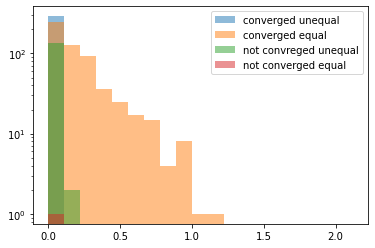

In [32]:
min_abs_llr = np.min(np.abs(var_beliefs[:,:,0] - var_beliefs[:,:,1]), axis=1)

finite_llrs = min_abs_llr[min_abs_llr < float('inf')]
if len(finite_llrs) == 0:
    raise Exception("all LLRs are infinite, plotting historgramm doesn't make sense")
max_finite_llr = np.max(finite_llrs)
min_abs_llr[min_abs_llr == float('inf')] = max_finite_llr
bins = np.linspace(0, max_finite_llr + 1, 20)

if converged_unequal_cnt > 0:
    print(f"converged unequal maximum min(abs(llr)): {np.max(min_abs_llr[converged_unequal])}")
    plt.hist(min_abs_llr[converged_unequal], bins, alpha=0.5, label="converged unequal", log=True)
if converged_equal_cnt > 0:
    print(f"converged equal minimum min(abs(llr)): {np.min(min_abs_llr[converged_equal])}")
    plt.hist(min_abs_llr[converged_equal], bins, alpha=0.5, label="converged equal", log=True)
if notconverged_unequal_cnt > 0:
    print(f"not converged unequal maximum min(abs(llr)): {np.max(min_abs_llr[notconverged_unequal])}")
    plt.hist(min_abs_llr[notconverged_unequal], bins, alpha=0.5, label="not convreged unequal", log=True)
if notconverged_equal_cnt > 0:
    print(f"not converged equal minimum min(abs(llr)): {np.min(min_abs_llr[notconverged_equal])}")
    plt.hist(min_abs_llr[notconverged_equal], bins, alpha=0.5, label="not converged equal", log=True)
plt.legend()
plt.show()